# 終点誤差分散最小モデル (minimum-variance model)
**終点誤差分散最小モデル** (minimum-variance model; Harris & Wolpert, 1998)を実装する．

$$
\mathbf{x}_{t+1} = A \mathbf{x}_t + B(u_t + w_t)
$$

$A\in \mathbb{R}^{n\times n}$, $B\in \mathbb{R}^{n}$

$\mathbf{x}_t$の平均は

$$
\mathrm{E}\left[\mathbf{x}_{t}\right]=A^{t} \mathbf{x}_{0}+\sum_{i=0}^{t-1} A^{t-1-i} \boldsymbol{B} u_{i}
$$

$\mathbf{x}_t$の分散は

$$
\operatorname{Cov}\left[\mathbf{x}_{t}\right]=k \sum_{i=0}^{t-1}\left(A^{t-1-i} \boldsymbol{B}\right)\left(A^{t-1-i} \boldsymbol{B}\right)^{\mathrm{T}} u_{i}^{2}
$$

## 終点誤差分散最小モデルの実装
以下では田中先生の<https://motorcontrol.jp/mc13/MC2019_2_OptimalControlStochastic.pdf>のコードを参考に作成した．

In [1]:
using LinearAlgebra, Random, ToeplitzMatrices, PyPlot

In [2]:
eye(T::Type, n) = Diagonal{T}(I, n)
eye(n) = eye(Float64, n)
vec(X) = vcat(X...)

vec (generic function with 1 method)

In [3]:
# Equality Constrained Quadratic Programming
function solveEqualityConstrainedQuadProg(P, q, A, b)
    """
    minimize   : 1/2 * x'*P*x + q'*x
    subject to : A*x = b
    """
    K = [P A'; A zeros(size(A)[1], size(A)[1])] # KKT matrix
    sol = K \ [-q; b]
    return sol[1:size(A)[2]]
end

solveEqualityConstrainedQuadProg (generic function with 1 method)

In [4]:
t1 = 224*1e-3 # time const of eye dynamics (s)
t2 = 13*1e-3  # another time const of eye dynamics (s)
tm = 10*1e-3
dt = 1e-3     # simulation time step (s)
tf = 50*1e-3  # movement duration (s)
tp = 20*1e-3  # post-movement duration (s)
ntf = round(Int, tf/dt)
ntp = round(Int, tp/dt)
nt = ntf + ntp # total time steps
trange = (1:nt) * dt * 1e3 # ms

x0 = zeros(3)       # initial state (pos=0, vel=0, acc=0)
xf = [10; zeros(2)] # final state (pos=10, vel=0, acc=0)
α1 = -1/(t1*t2*tm)
α2 = -1/(t1*t2)-1/(t1*tm)-1/(t2*tm)
α3 = -1/t1-1/t2-1/tm
Ac = [0 1 0; 0 0 1; α1 α2 α3];
Bc = [zeros(2); 1]
A = exp(Ac*dt);
B = Ac^-1 * (eye(3) - exp(Ac*dt))*Bc;

In [5]:
# calculation of Q
diagQ = zeros(nt);
for i=0:nt-1
    if i < ntf
        diagQ[i+1] = sum([(A^(k-i-1) * B * B' * A'^(k-i-1))[1,1] for k=ntf:nt-1])
    else
        diagQ[i+1] = diagQ[i] + (A^(nt-i-2) * B * B' * A'^(nt-i-2))[1,1]
    end
end
diagQ *= 10^13 # for numerical stability
Q = Diagonal(diagQ); 

制約条件における行列Cとベクトルdの計算．

In [6]:
# calculation of C
C = zeros((ntp+1)*3, nt);
for p=1:ntp+1
    for q=1:nt
        if ntf-1+(p-1)-(q-1) >= 0
            idx = 3*(p-1)+1:3*p
            C[idx, q] = A^(ntf-1-(q-1)+(p-1))*B # if ntf-1-(q-1)+(p-1) == 0; A^(ntf-1-(q-1)+(p-1))*B equal to B
        end
    end
end

In [7]:
# calculation of d
d = vec([xf - A^(ntf+i) * x0 for i=0:ntp]);

制御信号を二次計画法で計算．

In [8]:
# solution by quadratic programming
u = solveEqualityConstrainedQuadProg(Q, zeros(nt), C, d);

シミュレーションの実行．

In [9]:
# forward solution
x = zeros(3, nt);
x[:,1] = x0;
for k=1:nt-1
    x[:,k+1] = A*x[:, k] + B*u[k]
end

結果の描画．

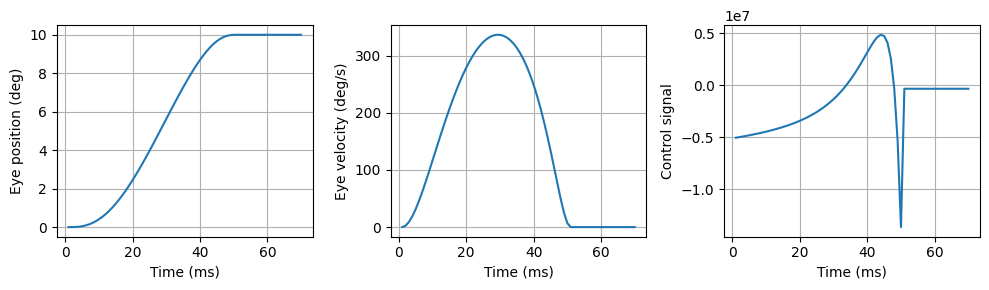

In [10]:
figure(figsize=(10, 3))
subplot(1,3,1)
plot(trange, x[1, :])
ylabel("Eye position (deg)"); xlabel("Time (ms)"); grid()
subplot(1,3,2)
plot(trange, x[2, :])
ylabel("Eye velocity (deg/s)"); xlabel("Time (ms)"); grid()
subplot(1,3,3)
plot(trange, u)
ylabel("Control signal"); xlabel("Time (ms)"); grid()
tight_layout()